In [4]:
# Load the data from 3 json files
import json
import matplotlib.pyplot as plt

with open('summary.json') as f:
    pre_summary = json.load(f)


In [5]:
summary = []
time_taken = []
total_cost = []
for case in pre_summary:
    new_case = {}
    new_case['num_functions'] = case['num_task_managers']
    new_case['price_per_request'] = case['cost'] / case['num_images']
    new_case['total_time'] = case['latency']
    new_case['duration_accumulated'] = case['duration_function']
    new_case['duration_init'] = case['duration_init']
    new_case['num_images'] = case['num_images']
    new_case['num_splits'] = case['num_splits']
    summary.append(new_case)
    time_taken.append(case['latency'])
    total_cost.append(case['cost'])
    
# Order summary by duration_init
summary = sorted(summary, key=lambda item: item["duration_init"])

print(f"Total cost: {sum(total_cost)}")
print(f"Time taken: {sum(time_taken)}")

Total cost: 4.746098549999999
Time taken: 1708.7746794223785


# Log Linear regression for Init Time

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

# Get all init times
init_times = [price_data['duration_init'] for price_data in summary]
print(init_times[:20])
num_functions = [int(price_data['num_functions']) for price_data in summary]
print(num_functions[:20])
init_times = np.array(init_times).reshape(-1, 1)
num_functions = np.array(num_functions).reshape(-1, 1)

[3.65925, 3.91687, 4.06729, 4.4280100000000004, 4.49497, 4.59416, 4.6304099999999995, 4.67943, 4.68108, 4.69888, 4.70515, 4.883970000000001, 5.11737, 5.14435, 5.35138, 10.646189999999999, 14.438130000000001, 30.98031, 31.980010000000004, 31.99761]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 6, 7, 7]


In [7]:
y = init_times.flatten()
y_log = np.log(y).reshape(-1, 1)
x_log = np.log(num_functions).reshape(-1, 1)
log_model_init = LinearRegression()
log_model_init.fit(x_log, y_log)
y_log_pred = log_model_init.predict(x_log)

# Print the coefficients
print("Coefficients:", log_model_init.coef_)
print("Intercept:", log_model_init.intercept_)




Coefficients: [[1.00304348]]
Intercept: [1.52235719]


H0: The residuals are NOT normally distributed.
H1: The residuals are normally distributed.

ln(pred) = 1.5223571854236164 + 1.0030434802604724 * ln(num_func)
pred = exp(1.5223571854236164) * exp(1.0030434802604724 * num_func)


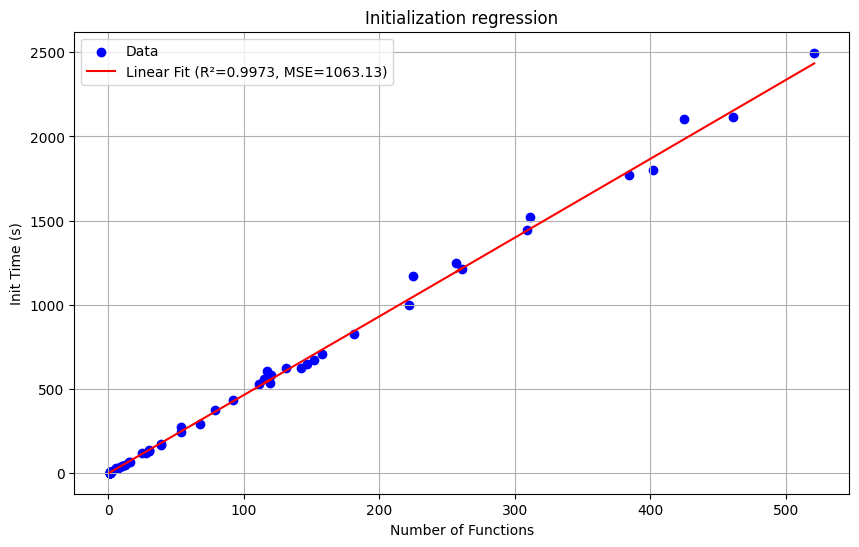

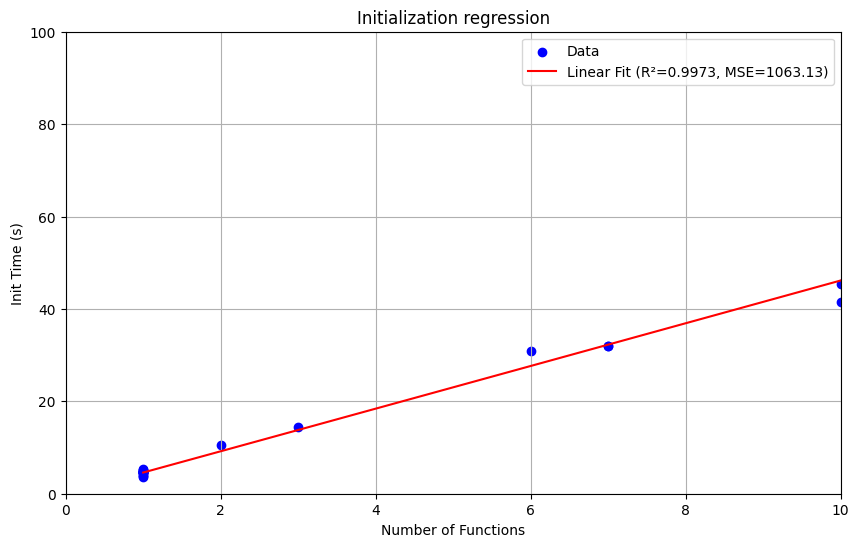

In [8]:
# Use the new linear_model_transformed to predict
init_coef = log_model_init.coef_[0][0]
init_intercept = log_model_init.intercept_[0]

def predict_log_model(num_func):
    # Convert input to a NumPy array for vectorized operations
    num_func = np.array(num_func)
    log_num_func = np.log(num_func)
    
    # Calculate log gestation using the linear model
    print(f"ln(pred) = {init_intercept} + {init_coef} * ln(num_func)")
    log_pred = init_intercept+ init_coef * log_num_func
    print(f"pred = exp({init_intercept}) * exp({init_coef} * num_func)")
    # Exponentiate to get the actual gestation lengths
    preds = np.exp(log_pred)
    return preds

def plot_linear_regression(num_functions, init_times, linear_pred):
    linear_r2 = r2_score(init_times, linear_pred)
    linear_mse = mean_squared_error(init_times, linear_pred)
    plt.figure(figsize=(10, 6))
    plt.scatter(num_functions, init_times, color='blue', label="Data")
    plt.plot(num_functions, linear_pred, color='red', label=f"Linear Fit (R²={linear_r2:.4f}, MSE={linear_mse:.2f})")
    plt.xlabel('Number of Functions')
    plt.ylabel('Init Time (s)')
    plt.title('Initialization regression')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_linear_regression_zoomed(num_functions, init_times, linear_pred):
    linear_r2 = r2_score(init_times, linear_pred)
    linear_mse = mean_squared_error(init_times, linear_pred)
    plt.figure(figsize=(10, 6))
    plt.scatter(num_functions, init_times, color='blue', label="Data")
    plt.plot(num_functions, linear_pred, color='red', label=f"Linear Fit (R²={linear_r2:.4f}, MSE={linear_mse:.2f})")
    plt.xlabel('Number of Functions')
    plt.ylabel('Init Time (s)')
    plt.title('Initialization regression')
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0, top=100)
    plt.xlim(left=0, right=10)
    plt.show()

# Define the range of birthweights and predict
predictions = predict_log_model(num_functions)
plot_linear_regression(num_functions, init_times, predictions)
plot_linear_regression_zoomed(num_functions, init_times, predictions)

In [9]:
general_r2 = r2_score(init_times, predictions)
general_mse = mean_squared_error(init_times, predictions)
general_mape = np.mean(np.abs((init_times - predictions) / init_times)) * 100

print(f"General R²: {general_r2}")
print(f"General MSE: {general_mse}")
print(f"General MAPE: {general_mape:.2f}%")

General R²: 0.9973082508659457
General MSE: 1063.1283087347354
General MAPE: 5.28%


# Multiple linear regression for Accumulated time

Multiple or multivariate linear regression is a case of linear regression with two or more independent variables.

If there are just two independent variables, then the estimated regression function is 𝑓(𝑥₁, 𝑥₂) = 𝑏₀ + 𝑏₁𝑥₁ + 𝑏₂𝑥₂. It represents a regression plane in a three-dimensional space. The goal of regression is to determine the values of the weights 𝑏₀, 𝑏₁, and 𝑏₂ such that this plane is as close as possible to the actual responses, while yielding the minimal SSR.

The case of more than two independent variables is similar, but more general. The estimated regression function is 𝑓(𝑥₁, …, 𝑥ᵣ) = 𝑏₀ + 𝑏₁𝑥₁ + ⋯ +𝑏ᵣ𝑥ᵣ, and there are 𝑟 + 1 weights to be determined when the number of inputs is 𝑟.



In [10]:
duration_accumulated = [price_data['duration_accumulated'] for price_data in summary]
duration_accumulated = np.array(duration_accumulated).reshape(-1, 1)
duration_accumulated_log = np.log(duration_accumulated).reshape(-1, 1)

num_images = [int(price_data['num_images']) for price_data in summary]
num_images_log = np.log(num_images).reshape(-1, 1)

num_functions = [int(price_data['num_functions']) for price_data in summary]
num_functions_log = np.log(num_functions).reshape(-1, 1)

X_log = np.hstack((num_images_log, num_functions_log))
log_model_acc = LinearRegression()
log_model_acc.fit(X_log, duration_accumulated_log)
linear_pred_log = log_model_acc.predict(X_log)

# Print the coefficients
print("Coefficients:", log_model_acc.coef_)
print("Intercept:", log_model_acc.intercept_)

Coefficients: [[0.7420595  0.22359156]]
Intercept: [-0.60361776]


## Using the new model with the logarithmic transformation

ln(pred) = -0.6036177577604791 + 0.7420595000601841 * ln(num_images) + 0.22359155532419306 * ln(num_functions)
pred = exp(-0.6036177577604791) * exp(0.7420595000601841 * num_images) * exp(0.22359155532419306 * num_functions)


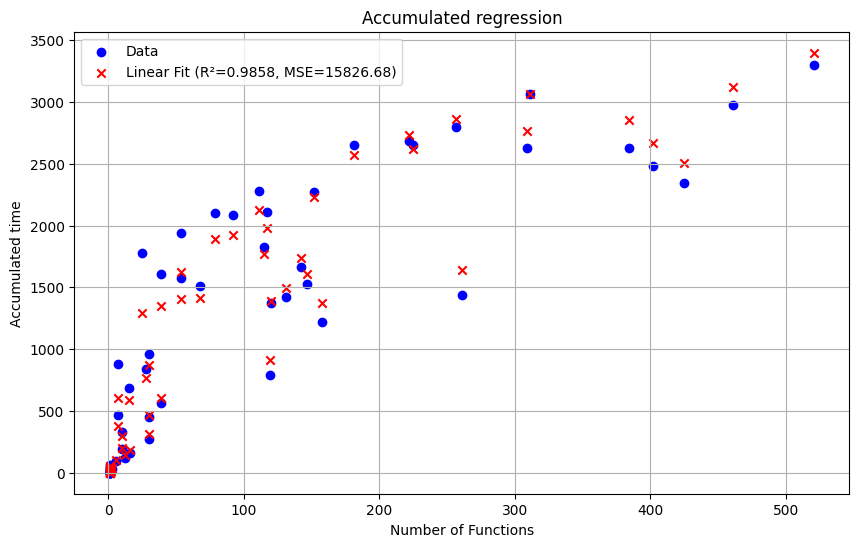

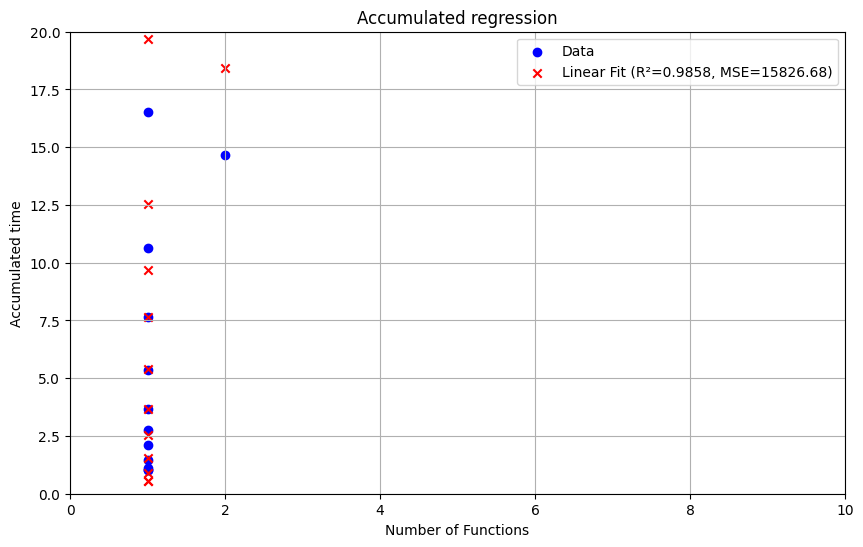

MAPE: 10192.47%


In [11]:
acc_coef_i = log_model_acc.coef_[0][0]
acc_coef_f = log_model_acc.coef_[0][1]
acc_intercept = log_model_acc.intercept_[0]

def predict_log_model_acc(num_images, num_functions):
    # Convert input to a NumPy array for vectorized operations
    num_images = np.array(num_images)
    num_functions = np.array(num_functions)
    log_num_images = np.log(num_images)
    log_num_functions = np.log(num_functions)
    
    # Calculate log gestation using the linear model
    print(f"ln(pred) = {acc_intercept} + {acc_coef_i} * ln(num_images) + {acc_coef_f} * ln(num_functions)")
    log_pred = acc_intercept + acc_coef_i * log_num_images + acc_coef_f * log_num_functions
    print(f"pred = exp({acc_intercept}) * exp({acc_coef_i} * num_images) * exp({acc_coef_f} * num_functions)")
    # Exponentiate to get the actual gestation lengths
    preds = np.exp(log_pred)
    return preds

predictions = predict_log_model_acc(num_images, num_functions)

def plot_linear_regression_acc(num_functions, duration_accumulated, predictions):
    linear_r2 = r2_score(duration_accumulated, predictions)
    linear_mse = mean_squared_error(duration_accumulated, predictions)
    plt.figure(figsize=(10, 6))
    plt.scatter(num_functions, duration_accumulated, color='blue', label="Data")
    plt.scatter(num_functions, predictions, color='red', label=f"Linear Fit (R²={linear_r2:.4f}, MSE={linear_mse:.2f})", marker='x')
    plt.xlabel('Number of Functions')
    plt.ylabel('Accumulated time')
    plt.title('Accumulated regression')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_linear_regression_acc_zoom(num_functions, duration_accumulated, predictions):
    linear_r2 = r2_score(duration_accumulated, predictions)
    linear_mse = mean_squared_error(duration_accumulated, predictions)
    plt.figure(figsize=(10, 6))
    plt.scatter(num_functions, duration_accumulated, color='blue', label="Data")
    plt.scatter(num_functions, predictions, color='red', label=f"Linear Fit (R²={linear_r2:.4f}, MSE={linear_mse:.2f})", marker='x')
    plt.xlabel('Number of Functions')
    plt.ylabel('Accumulated time')
    plt.title('Accumulated regression')
    plt.legend()
    plt.grid(True)
    plt.xlim(left=0, right=10)
    plt.ylim(bottom=0, top=20)
    plt.show()


plot_linear_regression_acc(num_functions, duration_accumulated, predictions)
plot_linear_regression_acc_zoom(num_functions, duration_accumulated, predictions)
# MAPE
mape = np.mean(np.abs((duration_accumulated - predictions) / duration_accumulated)) * 100
print(f"MAPE: {mape:.2f}%")




In [12]:

general_r2 = r2_score(duration_accumulated, predictions)
general_mse = mean_squared_error(duration_accumulated, predictions)
general_mape = np.mean(np.abs((duration_accumulated - predictions) / duration_accumulated)) * 100

print(f"General R²: {general_r2}")
print(f"General MSE: {general_mse}")
print(f"General MAPE: {general_mape:.2f}%")

General R²: 0.9858129999188762
General MSE: 15826.67676260598
General MAPE: 10192.47%


ln(pred) = -0.6036177577604791 + 0.7420595000601841 * ln(num_images) + 0.22359155532419306 * ln(num_functions)
pred = exp(-0.6036177577604791) * exp(0.7420595000601841 * num_images) * exp(0.22359155532419306 * num_functions)
ln(pred) = -0.6036177577604791 + 0.7420595000601841 * ln(num_images) + 0.22359155532419306 * ln(num_functions)
pred = exp(-0.6036177577604791) * exp(0.7420595000601841 * num_images) * exp(0.22359155532419306 * num_functions)


/tmp/ipykernel_100536/1429130294.py:10: RuntimeWarning: divide by zero encountered in log
  log_num_functions = np.log(num_functions)


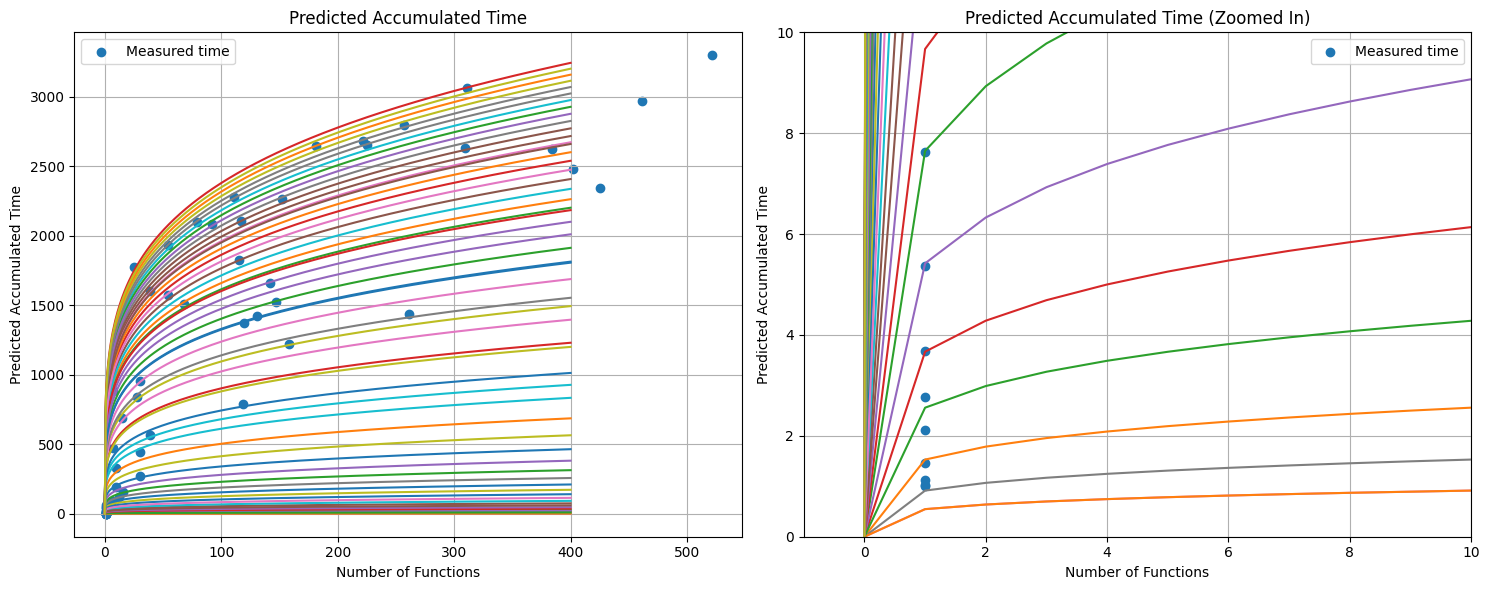

In [13]:
def plot_multi_linear_regression(num_images, num_functions, duration_accumulated):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # First plot
    axs[0].scatter(num_functions, duration_accumulated, label="Measured time")
    num_functions_range = np.arange(0, 401).reshape(-1, 1)
    predictions = predict_log_model_acc(num_images, num_functions_range)
    axs[0].plot(num_functions_range, predictions)

    axs[0].set_xlabel('Number of Functions')
    axs[0].set_ylabel('Predicted Accumulated Time')
    axs[0].set_title('Predicted Accumulated Time')
    axs[0].grid(True)
    axs[0].legend()

    # Second plot (zoomed in)
    axs[1].scatter(num_functions, duration_accumulated, label="Measured time")

    predictions = predict_log_model_acc(num_images, num_functions_range)
    axs[1].plot(num_functions_range, predictions)

    axs[1].set_xlabel('Number of Functions')
    axs[1].set_ylabel('Predicted Accumulated Time')
    axs[1].set_title('Predicted Accumulated Time (Zoomed In)')
    axs[1].grid(True)
    axs[1].legend()
    axs[1].set_xlim(left=-1, right=10)
    axs[1].set_ylim(bottom=0, top=10)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function with your data
plot_multi_linear_regression(num_images, num_functions, duration_accumulated)


# Saving models

In [14]:
log_coeficients = {
    "init": {
        "coef": log_model_init.coef_[0][0],
        "intercept": log_model_init.intercept_[0]
    },
    "acc": {
        "coef_i": log_model_acc.coef_[0][0],
        "coef_f": log_model_acc.coef_[0][1],
        "intercept": log_model_acc.intercept_[0]
    }
}
# Save coeficients to a file
with open("models/optimizer_model.json", "w") as file:
    json.dump(log_coeficients, file)

FileNotFoundError: [Errno 2] No such file or directory: 'models/log_coeficients.json'

In [29]:
# Save in summary.csv
import pandas as pd

summary_df = pd.DataFrame(summary)
summary_df['init_coef_f'] = log_model_init.coef_[0][0]
summary_df['init_intercept'] = log_model_init.intercept_[0]
summary_df['exec_coef_i'] = log_model_acc.coef_[0][0]
summary_df['exec_coef_f'] = log_model_acc.coef_[0][1]
summary_df['exec_intercept'] = log_model_acc.intercept_[0]
summary_df.to_csv("summary.csv", index=False)

# Log model 

/tmp/ipykernel_783403/74964907.py:11: RuntimeWarning: divide by zero encountered in log
  log_num_functions = np.log(num_functions)


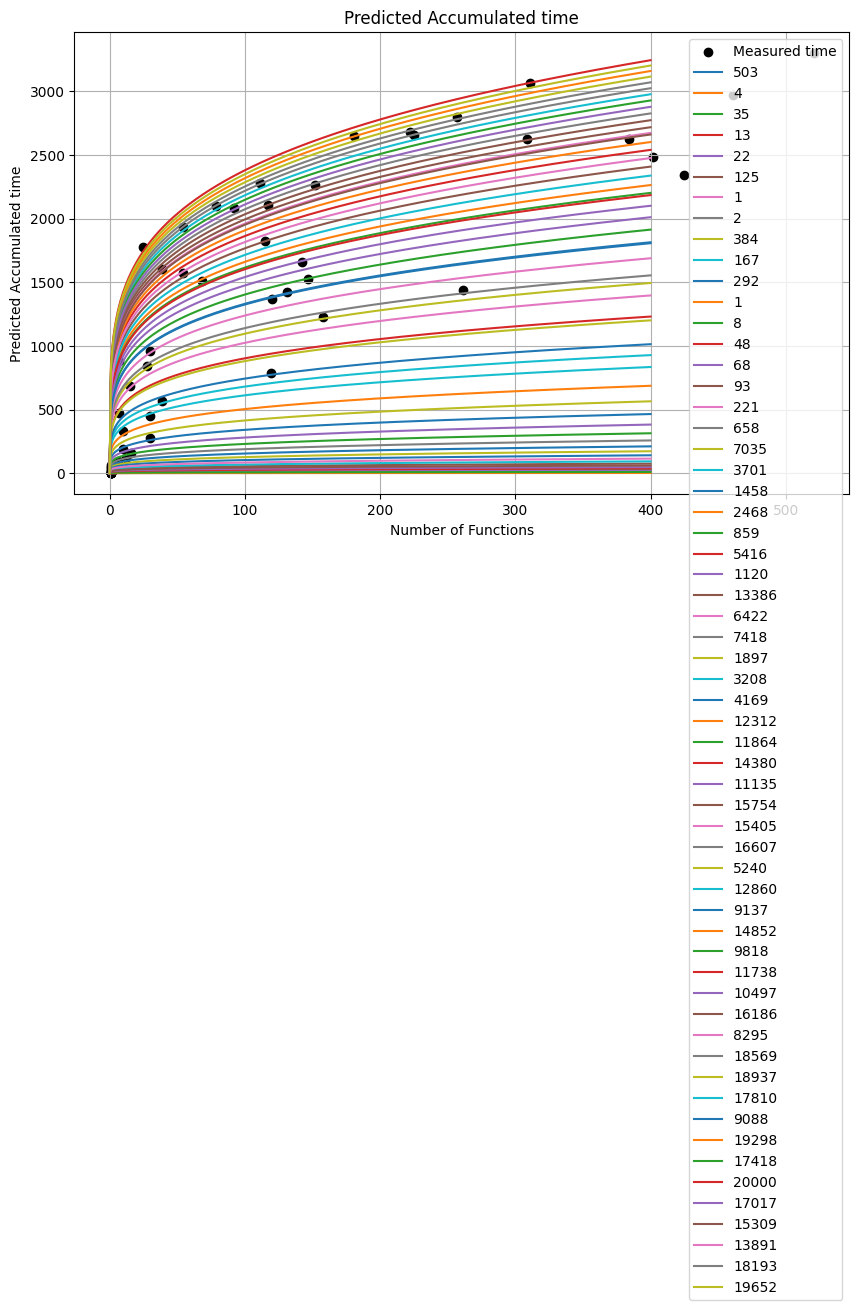

In [30]:
class LogPredictorAcc:
    def __init__(self, coefficient_num_images, coefficient_num_functions, intercept):
        self.coefficient_num_images = coefficient_num_images
        self.coefficient_num_functions = coefficient_num_functions
        self.intercept = intercept

    def predict_duration_range(self, num_images_array, num_functions_array):
        num_images = np.array(num_images_array)
        num_functions = np.array(num_functions_array)
        log_num_images = np.log(num_images)
        log_num_functions = np.log(num_functions)
        log_pred = self.intercept + self.coefficient_num_images * log_num_images + self.coefficient_num_functions * log_num_functions
        preds = np.exp(log_pred)
        return preds
            
log_predictor_acc = LogPredictorAcc(coefficient_num_images=log_coeficients['acc']['coef_i'], 
                             coefficient_num_functions=log_coeficients['acc']['coef_f'],
                             intercept=log_coeficients['acc']['intercept'])

# Define the range of num_functions and predict for fixed num_images values
num_functions_range = np.arange(0, 401)
duration_accumulated = [price_data['duration_accumulated'] for price_data in summary]
num_functions = [int(price_data['num_functions']) for price_data in summary]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(num_functions, duration_accumulated, color='black', label="Measured time")

for i, n_img in enumerate(num_images):
    prediction = log_predictor_acc.predict_duration_range(n_img, num_functions_range)
    plt.plot(num_functions_range, prediction, label=f"{n_img}")
plt.xlabel('Number of Functions')
plt.ylabel('Predicted Accumulated time')
plt.title(f'Predicted Accumulated time')
plt.grid(True)
plt.legend()
# Set y and x to start at 0
# plt.ylim(bottom=0, top=100)
# plt.xlim(left=0, right=10)
plt.show()

/tmp/ipykernel_783403/412750685.py:8: RuntimeWarning: divide by zero encountered in log
  log_num_func = np.log(num_func)


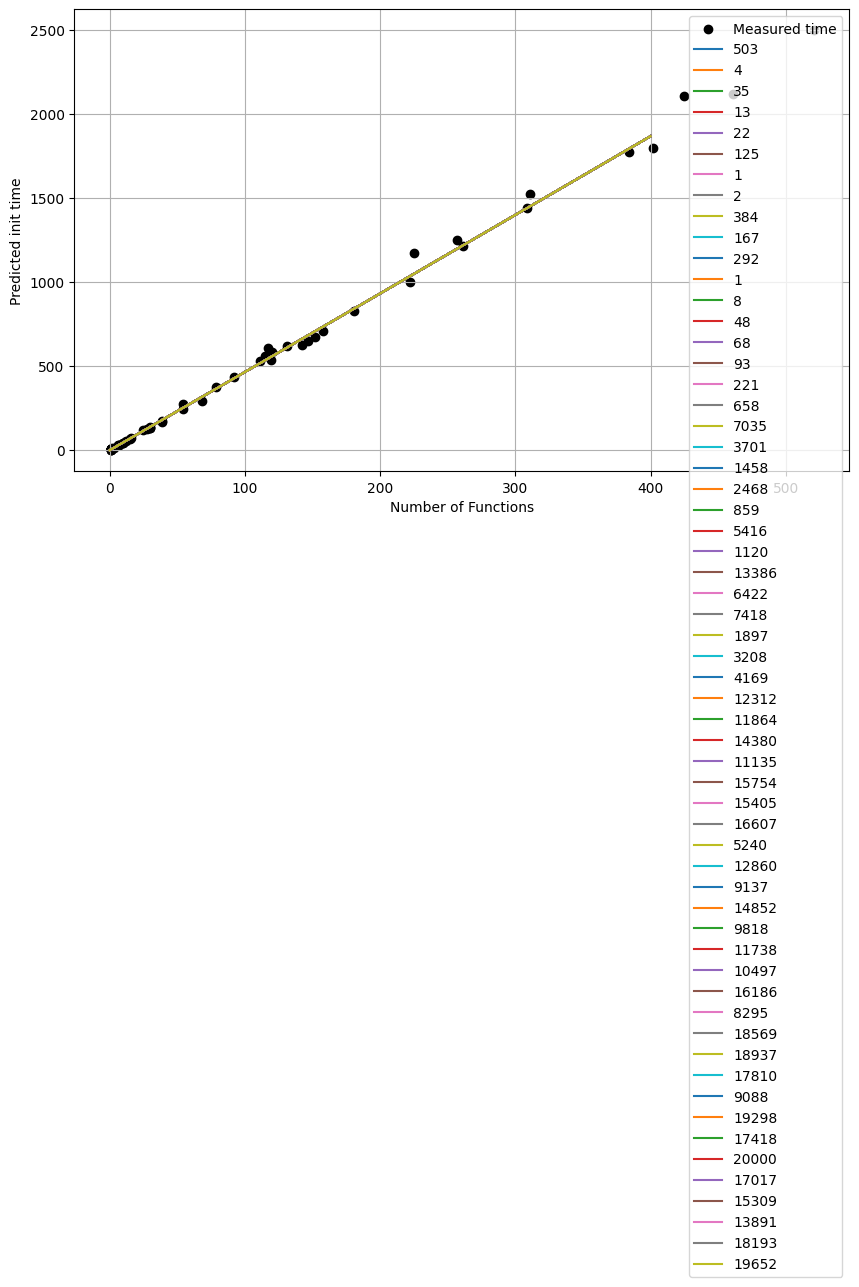

In [31]:
class LogPredictorInit:
    def __init__(self, coefficient_num_functions, intercept):
        self.coefficient_num_functions = coefficient_num_functions
        self.intercept = intercept
        
    def predict_init_time(self, num_functions):
        num_func = np.array(num_functions)
        log_num_func = np.log(num_func)
        log_pred = self.intercept + self.coefficient_num_functions * log_num_func
        preds = np.exp(log_pred)
        return preds
    
    
log_predictor_init = LogPredictorInit(
    coefficient_num_functions=log_coeficients['init']['coef'], 
    intercept=log_coeficients['init']['intercept']
)

# Define the range of num_functions and predict for fixed n_img values
num_functions_range = np.arange(0, 401)
init_times = [price_data['duration_init'] for price_data in summary]
num_functions = [int(price_data['num_functions']) for price_data in summary]

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(num_functions, init_times, color='black', label="Measured time")
for i, n_img in enumerate(num_images):
    prediction = log_predictor_init.predict_init_time(num_functions_range)
    plt.plot(num_functions_range, prediction, label=f"{n_img}")
plt.xlabel('Number of Functions')
plt.ylabel('Predicted init time')
plt.grid(True)
plt.legend()
# Set y and x to start at 0
# plt.ylim(bottom=0, top=100)
# plt.xlim(left=0, right=10)
plt.show()



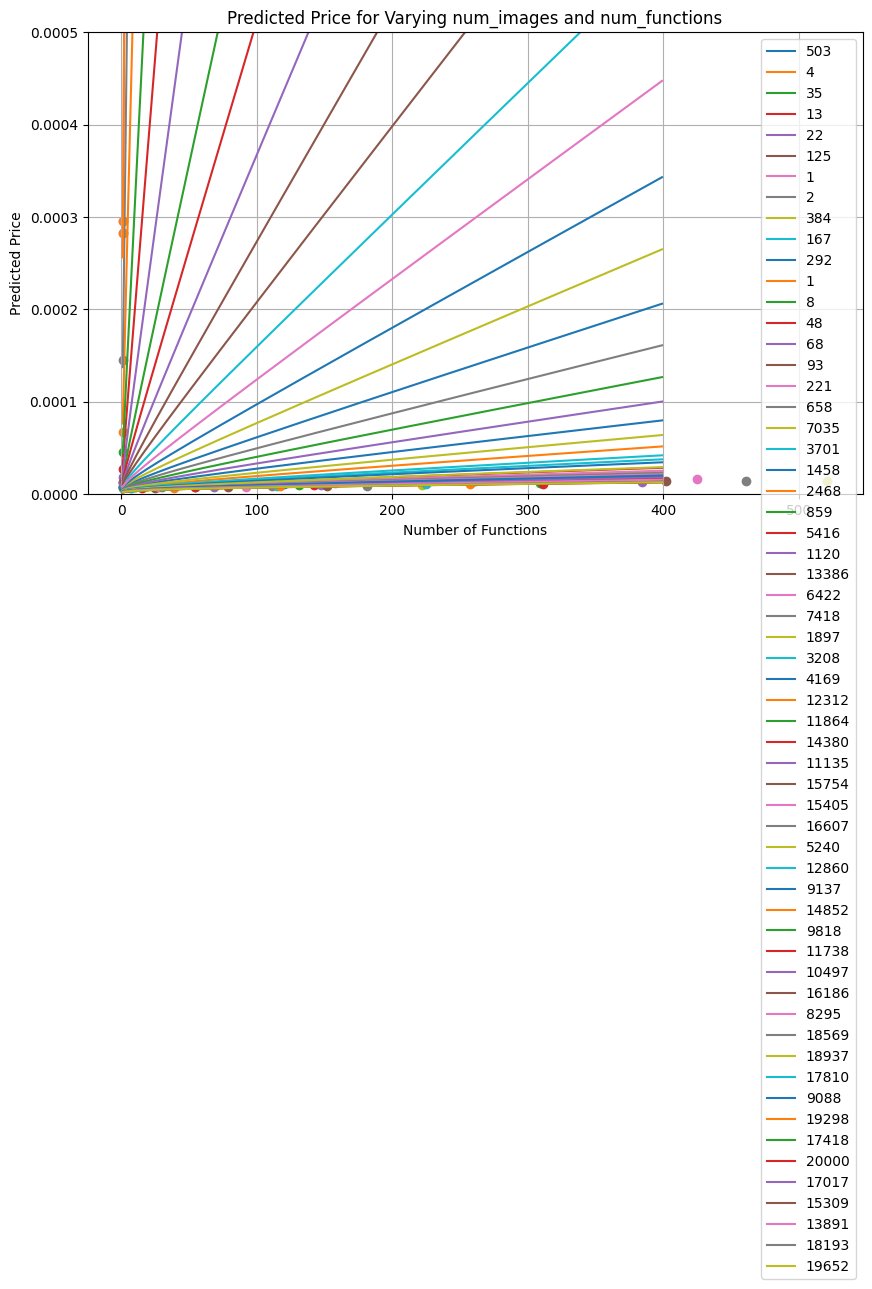

In [32]:
num_functions_range = np.arange(1, 400)
price_per_request = [price_data['price_per_request'] for price_data in summary]

# Initialize the plot
plt.figure(figsize=(10, 6))

# Loop through each num_images value and predict
for n_img in num_images:
    prediction_acc = log_predictor_acc.predict_duration_range(n_img, num_functions_range)
    prediction_init = log_predictor_init.predict_init_time(num_functions_range)
    billed_predictions = prediction_acc + prediction_init

    # Multiply by the rate to get the price
    price_predictions = billed_predictions * 0.0000000500 * 1000 / n_img

    scatter_num_functions = []
    scatter_prices = []
    for num_func, num_im, price in zip(num_functions, num_images, price_per_request):
        if num_im == n_img:
            scatter_num_functions.append(num_func)
            scatter_prices.append(price)
    plt.scatter(scatter_num_functions, scatter_prices)
    # Plot the result for this num_images value
    plt.plot(num_functions_range, price_predictions, label=f"{n_img}")

# Configure the plot
plt.xlabel('Number of Functions')
plt.ylabel('Predicted Price')
plt.title('Predicted Price for Varying num_images and num_functions')
plt.grid(True)
plt.legend()
plt.ylim(bottom=0, top=0.0005)
plt.show()

    
    

R²: 0.9932078147263917
R²: 0.9856399878976213, MSE: 4.090721211829773e-11, MAPE: 8.50%


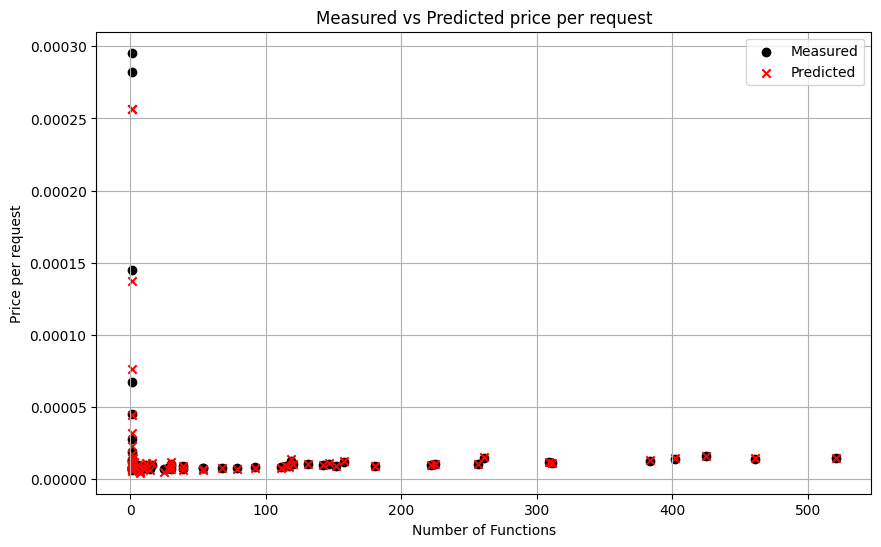

In [33]:
PRICE_PER_SECOND = 0.0000000500 * 1000
real_prices = [price_data['price_per_request'] for price_data in summary]
real_billed = [price_data['duration_accumulated'] + price_data['duration_init'] for price_data in summary]

prediction_acc = log_predictor_acc.predict_duration_range(np.array(num_images), np.array(num_functions))
prediction_init = log_predictor_init.predict_init_time(np.array(num_functions))
billed_predictions = prediction_acc + prediction_init
print(f"R²: {r2_score(real_billed, billed_predictions)}")
# Multiply by the rate to get the price
price_predictions = billed_predictions * PRICE_PER_SECOND / num_images
r2 = r2_score(real_prices, price_predictions)
mse = mean_squared_error(real_prices, price_predictions)
mape = np.mean(np.abs((real_prices - price_predictions) / real_prices)) * 100
print(f"R²: {r2}, MSE: {mse}, MAPE: {mape:.2f}%")

# Present all points 
plt.figure(figsize=(10, 6))
plt.scatter(num_functions, real_prices, label="Measured", color='black')
plt.scatter(num_functions, price_predictions, label="Predicted", color='red', marker='x')
plt.xlabel('Number of Functions')
plt.ylabel('Price per request')
plt.title('Measured vs Predicted price per request')
plt.grid(True)
plt.legend()
plt.show()



R² for all images: 0.9856399878976213, MSE: 4.090721211829773e-11, MAPE: 8.50%


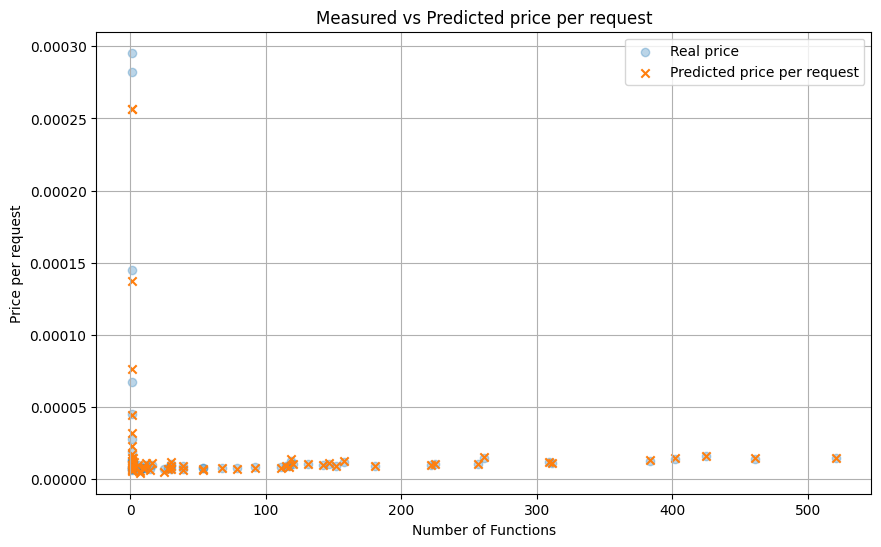

In [34]:
plt.figure(figsize=(10, 6))


plt.scatter(num_functions, real_prices,  alpha = 0.3, label=f'Real price')

# Predict the time
prediction_acc = log_predictor_acc.predict_duration_range(num_images, np.array(num_functions))
prediction_init = log_predictor_init.predict_init_time(np.array(num_functions))
billed_predictions = prediction_acc + prediction_init

# Multiply by the rate to get the price
price_predictions = billed_predictions * PRICE_PER_SECOND / num_images
price_predictions = np.array(price_predictions)
# Plot the result for this unique_num_images value
plt.scatter(num_functions, price_predictions, label=f"Predicted price per request", marker='x')

r2 = r2_score(real_prices, price_predictions)
mse = mean_squared_error(real_prices, price_predictions)
mape = np.mean(np.abs((real_prices - price_predictions) / real_prices)) * 100
print(f"R² for all images: {r2}, MSE: {mse}, MAPE: {mape:.2f}%")

plt.xlabel('Number of Functions')
plt.ylabel('Price per request')
plt.title('Measured vs Predicted price per request')
plt.grid(True)
plt.legend()
plt.show()

# Inversion

In [35]:
from scipy.optimize import fsolve
import numpy as np

class PredictorF:
    def __init__(self, init_coeficient_f, init_intercept, acc_coeficient_i, acc_coeficient_f, acc_intercept, price_per_second):
        self.init_coeficient_f = init_coeficient_f  # alpha_1
        self.init_intercept = init_intercept        # alpha_0
        self.acc_coeficient_i = acc_coeficient_i    # beta_2
        self.acc_coeficient_f = acc_coeficient_f    # beta_1
        self.acc_intercept = acc_intercept          # beta_3
        self.price_per_second = price_per_second
        
    def predict_price_per_request(self, num_functions, num_images):
        log_num_images = np.log(num_images)
        log_num_functions = np.log(num_functions)
        log_term_a = log_num_images * self.acc_coeficient_i + log_num_functions * self.acc_coeficient_f + self.acc_intercept
        term_a = np.exp(log_term_a)
        log_term_i = log_num_functions * self.init_coeficient_f + self.init_intercept
        term_i = np.exp(log_term_i)
        total = term_a + term_i
        price_per_request = total * self.price_per_second / num_images
        return price_per_request
    
    
    def predict_num_functions_exhaustive(self, price_limit, num_images, min_functions=1, max_functions=1000, step=1):
        # List from min_functions to max_functions
        num_functions_range = np.arange(min_functions, max_functions, step)
        prices = []
        for num_functions in num_functions_range:
            price = self.predict_price_per_request(num_functions, num_images)
            prices.append(price)
        prices = np.array(prices)
        idx = np.where(prices <= price_limit)
        return max(num_functions_range[idx])


# Example usage
price_limit = 0.0001
num_images = 1000
price_per_second = 0.0000000500 * 1000
acc_coefficient_num_images=log_coeficients['acc']['coef_i']
acc_coefficient_num_functions=log_coeficients['acc']['coef_f']
acc_intercept=log_coeficients['acc']['intercept']
init_coefficient_num_functions=log_coeficients['init']['coef']
init_intercept=log_coeficients['init']['intercept']


# Initialize with coefficients and intercepts
# predictor = PredictorF(init_coeficient_f=0.5, init_intercept=1.0, 
#                        acc_coeficient_i=0.3, acc_coeficient_f=0.7, acc_intercept=2.0,
#                        price_per_second=price_per_second)
predictor = PredictorF(init_coeficient_f=init_coefficient_num_functions, 
                       init_intercept=init_intercept, 
                       acc_coeficient_i=acc_coefficient_num_images, 
                       acc_coeficient_f=acc_coefficient_num_functions, 
                       acc_intercept=acc_intercept,
                       price_per_second=price_per_second)

predicted_price = predictor.predict_price_per_request(num_functions=10,
                                                    num_images=num_images)
print("Predicted price per request:", predicted_price)

predicted_n_f = predictor.predict_num_functions_exhaustive(predicted_price, num_images)
print("Predicted number of functions (n_f):", predicted_n_f)





Predicted price per request: 1.000942206069092e-05
Predicted number of functions (n_f): 10
